# Check model integrity
1. Explore Quetzal model integrity methods
2. Fix methods
3. Test methods
4. First insight of quetzal plot methods

In [5]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [19]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel, model
import geopandas as gpd
if manual:
    %matplotlib inline

In [20]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'
plot_path = training_folder + 'outputs/plot/'

In [21]:
sm = stepmodel.read_zip(training_folder + 'model/base/base.zip')

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 22.12it/s]


In [22]:
sm.nodes.index = sm.nodes['stop_id']

# add road

In [23]:
road_links = gpd.read_file(input_folder+'road/road_links.geojson', driver='GeoJSON')
road_nodes = gpd.read_file(input_folder+'road/road_nodes.geojson', driver='GeoJSON')
road_nodes.set_index('index', inplace=True)
sm.road_links = road_links
sm.road_nodes = road_nodes

In [24]:
road_links.head()

,index,a,b,length,geometry
0,2,166297606,25240349,311.138,"LINESTRING (2.36014 48.81642, 2.35595 48.81673)"
1,3,166297606,249076496,42.131,"LINESTRING (2.36014 48.81642, 2.36015 48.81605)"
2,4,271450120,27339859,96.693,"LINESTRING (2.27789 48.87569, 2.27904 48.87587)"
3,5,271450120,442306,103.415,"LINESTRING (2.27789 48.87569, 2.27852 48.87494)"
4,8,166297610,166300778,64.116,"LINESTRING (2.36065 48.81587, 2.36050 48.81641)"


# road integrity

## road_fix

In [25]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 6258it [00:04, 1308.43it/s]
reversed: 6258it [00:04, 1287.77it/s]
5926it [00:04, 1299.49it/s]


## road_test

In [26]:
sm.integrity_test_dead_ends()

5926it [00:01, 3487.24it/s]


In [27]:
sm.integrity_test_isolated_roads()

In [28]:
sm.integrity_test_road_nodeset_consistency()

# Transport Integrity

## transport_fix

In [30]:
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()

## transport_test

In [31]:
sm.integrity_test_circular_lines()
sm.integrity_test_sequences()

# Model integrity

Check the index of nodes, links, road_nodes, road_links and zones before and after applying the integrity_fix_collision method.

In [32]:
sm.integrity_fix_collision()
sm.integrity_fix_nodeset_consistency()

In [33]:
sm.integrity_test_collision()
sm.integrity_test_nodeset_consistency()

In [34]:
sm.integrity_test_all(errors='raise')

0it [00:00, ?it/s]

passed: integrity_test_circular_lines
passed: integrity_test_collision


5926it [00:01, 3962.70it/s]


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


5926it [00:04, 1293.57it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


# Plot methods

Using basemaps in Quetzal plots requires the model to be in EPSG 3857

In [35]:
sm = sm.change_epsg(epsg=3857, coordinates_unit='meter')

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████████████████████████████| 39/39 [00:08<00:00,  4.52it/s]


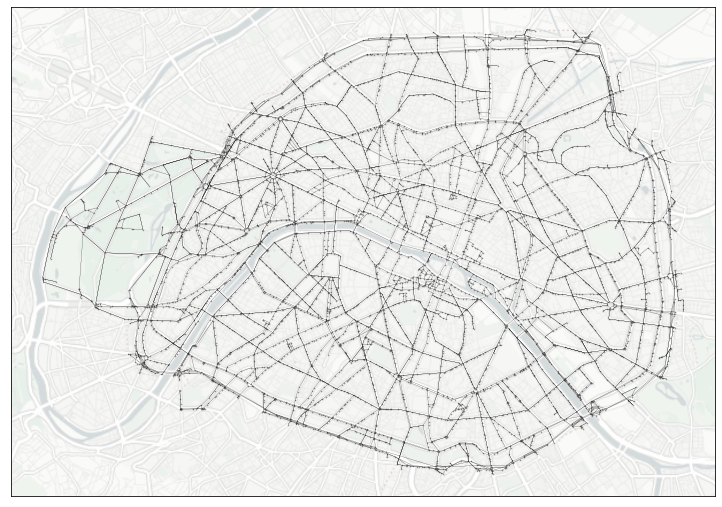

In [49]:
if manual:
    sm.plot(
        'road_nodes', color='grey', markersize=0.2,
        ax=sm.plot(
            'road_links', figsize=[16, 9], 
            basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', linewidth=0.2, color='black'
        ),    
    )

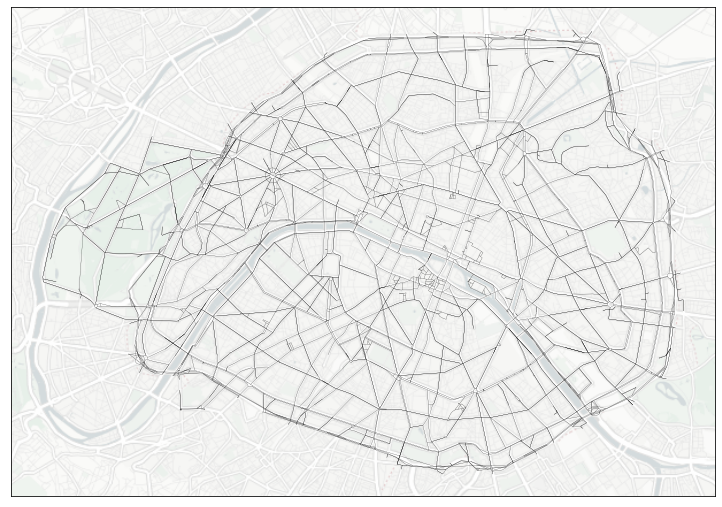

In [50]:
sm.plot(
        'road_links', figsize=[16, 9], 
        basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', linewidth=0.2, color='black'
        )

1. Identify which parameters of the above plot method are specific to quetzal model plot method and which are common to geopandas plot method.
2. Plot sm.zones using sm.plot method
3. Simultaneously plot zones, links and nodes with a basemap

# to_zip

In [51]:
sm.to_zip(training_folder + 'model/base/networks.zip')   

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.06it/s]


could not save attribute: missing_road_nodes
could not save attribute: missing_nodes
could not save attribute: orphan_nodes


# END